In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,poisson_glm
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix
from experiments import training_loop
from plotting_funcs import plot_losses, plot_frontier, plot_histograms

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

2024-05-05 06:03:33.259626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 06:03:34.004893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 06:03:34.004945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 06:03:34.024978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 06:03:34.090792: I tensorflow/core/platform/cpu_feature_guar

In [64]:
seed=360
num_components=4
learning_rate = 0.005
epochs=1250
outdir = '/cluster/home/kheuto01/testdir'
penalty = 5000
threshold = 0.6
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500

In [3]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed)

input_shape = (H,S)

negative_bpr_K = get_bpr_loss_func(K)

In [4]:
mix_model, mix_weights  = mixture_poissons(poisson_glm, input_shape, num_components=num_components)

In [5]:
for index in [0, 2, 4, 6]:
    variable = mix_model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))
for index, bias in zip([1, 3, 5, 7], [0.0+1e-13, 7.0, 10.0, 100.0]):
    variable = mix_model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))
index = -1
variable = mix_model.trainable_variables[index]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')

# equal to 0
component_1 = np.array([0,0,0,0, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9], dtype=np.float32)
# equal to 7
component_2 = np.array([1,1,1,1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32)
# equal to 10
component_3 = np.array([0,0,0,0, 0.7, 0.7, 0.7, 0.7, 0, 0, 0, 0], dtype=np.float32)
# equal to 10
component_4 = np.array([0,0,0,0, 0,0,0,0, 0.1, 0.1, 0.1, 0.1], dtype=np.float32)

weights = np.vstack([component_1, component_2, component_3, component_4])
variable.assign(tf.math.log(weights+1e-13))

Name: conv1d/kernel:0
Shape: (1, 3, 1)
Name: conv1d_1/kernel:0
Shape: (1, 3, 1)
Name: conv1d_2/kernel:0
Shape: (1, 3, 1)
Name: conv1d_3/kernel:0
Shape: (1, 3, 1)
Name: conv1d/bias:0
Shape: (1,)
Name: conv1d_1/bias:0
Shape: (1,)
Name: conv1d_2/bias:0
Shape: (1,)
Name: conv1d_3/bias:0
Shape: (1,)
Name: Variable:0
Shape: (4, 12)


<tf.Variable 'UnreadVariable' shape=(4, 12) dtype=float32, numpy=
array([[-29.933605  , -29.933605  , -29.933605  , -29.933605  ,
         -1.2039728 ,  -1.2039728 ,  -1.2039728 ,  -1.2039728 ,
         -0.10536054,  -0.10536054,  -0.10536054,  -0.10536054],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        -29.933605  , -29.933605  , -29.933605  , -29.933605  ,
        -29.933605  , -29.933605  , -29.933605  , -29.933605  ],
       [-29.933605  , -29.933605  , -29.933605  , -29.933605  ,
         -0.35667497,  -0.35667497,  -0.35667497,  -0.35667497,
        -29.933605  , -29.933605  , -29.933605  , -29.933605  ],
       [-29.933605  , -29.933605  , -29.933605  , -29.933605  ,
        -29.933605  , -29.933605  , -29.933605  , -29.933605  ,
         -2.3025851 ,  -2.3025851 ,  -2.3025851 ,  -2.3025851 ]],
      dtype=float32)>

In [6]:
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)

y_preds = mix_model(train_X_THS)

In [7]:
nll = mixture_poi_loss(train_y_TS, y_preds)
bpr = mix_bpr(train_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [62]:
import matplotlib.pyplot as plt



(4, 12)


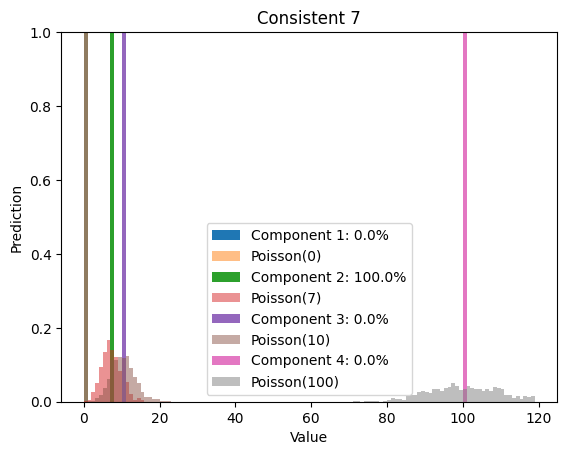

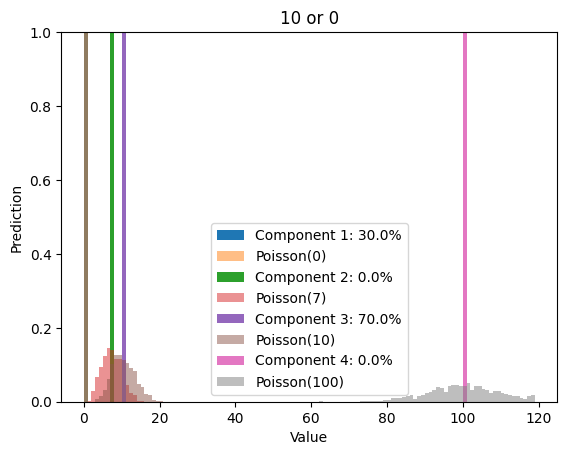

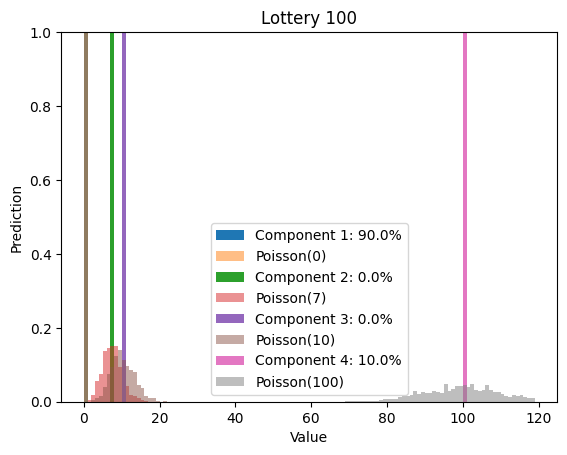

In [63]:
plot_component_histograms(y_preds)

In [17]:
y_preds[1].shape

TensorShape([4, 12])

(array([0.        , 0.        , 0.01666667, 0.06666667, 0.09333333,
        0.11666667, 0.15333333, 0.14333333, 0.13666667, 0.08333333,
        0.07      , 0.05666667, 0.03333333, 0.02333333, 0.00666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

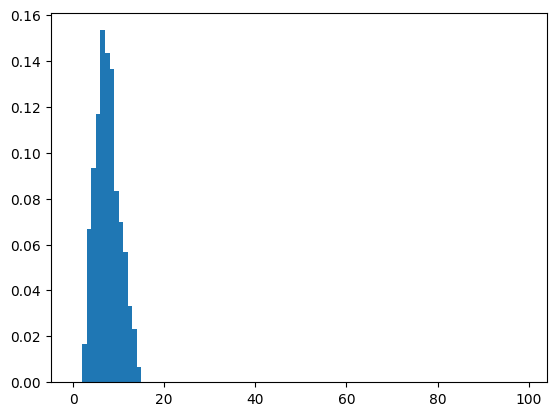

In [37]:
fig, ax = plt.subplots()
ax.hist(np.random.poisson(7, 300),
                      bins=range(min), label=f'Poisson({7})', density=True)

ax.hist()

In [65]:
mix_model_penalized, _  = mixture_poissons(poisson_glm, input_shape, num_components=num_components)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
penalized_bpr_loss = get_penalized_bpr_loss_func_mix(mixture_poi_loss, K, penalty, threshold)
losses_penalized = training_loop(mix_model_penalized, penalized_bpr_loss, optimizer,
                                    200, train_dataset, val_dataset, negative_bpr_K,
                                    verbose=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0: 937.2205200195312
1: 932.1969604492188
2: 928.7262573242188
3: 924.3623657226562
4: 919.6744995117188
5: 915.8414306640625
6: 910.710205078125
7: 907.4299926757812
8: 902.3223876953125
9: 897.6148071289062
10: 893.8823852539062
11: 890.263427734375
12: 886.1292724609375
13: 881.977600097656

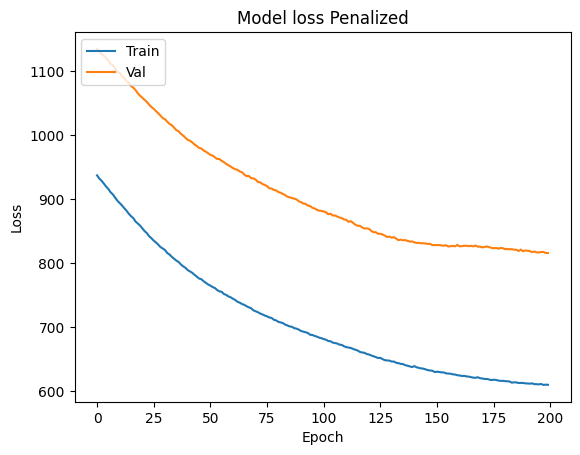

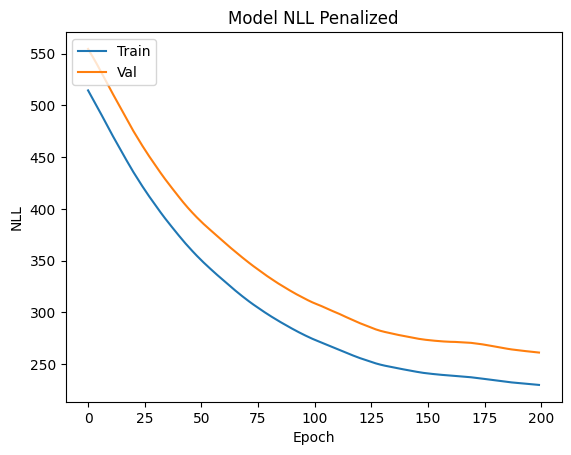

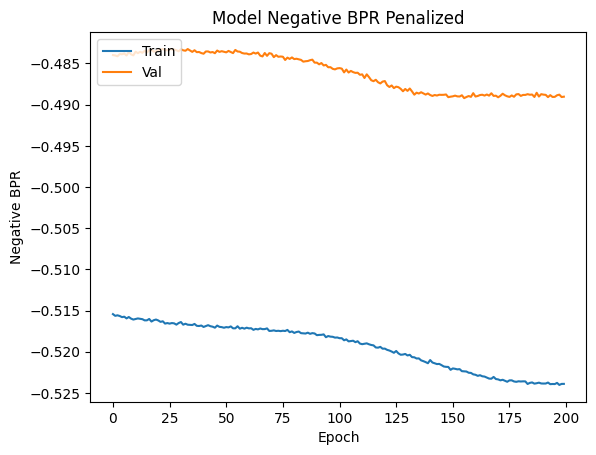

In [66]:
plot_losses(losses_penalized, title_add='Penalized', save_dir=None, file_add='penalized')


In [67]:

y_preds = mix_model_penalized(train_X_THS)

(4, 12)


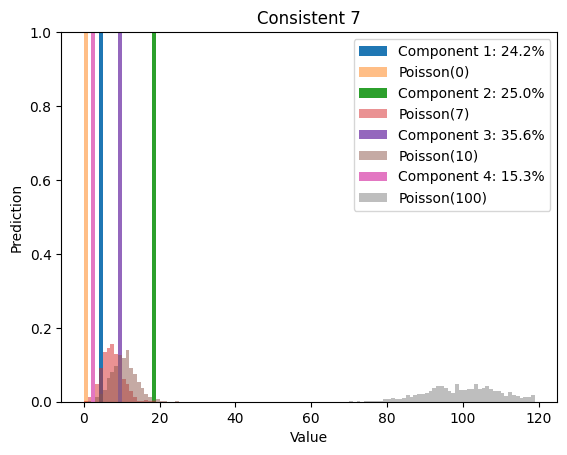

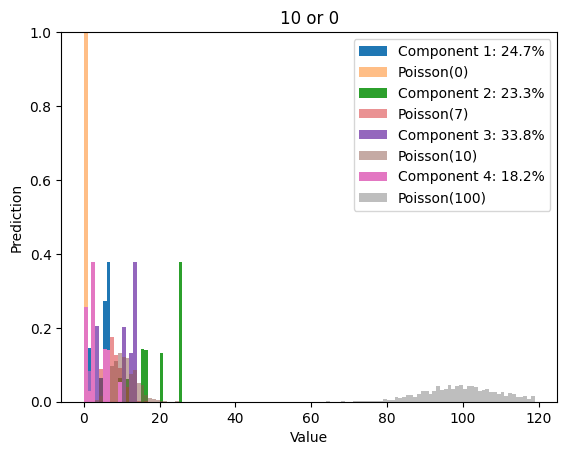

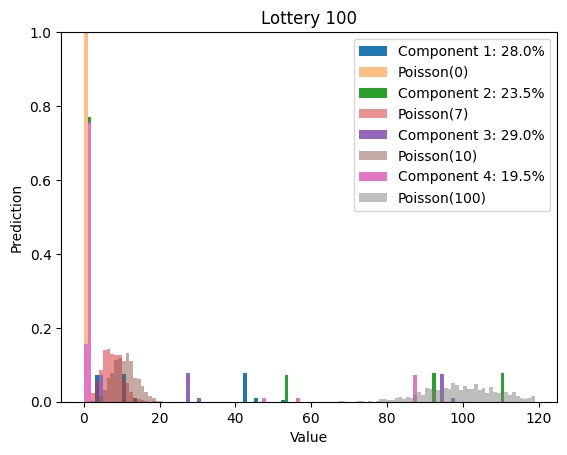

In [68]:
plot_component_histograms(y_preds)

In [69]:
mix_model_penalized.trainable_variables

[<tf.Variable 'conv1d_4/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.41955233],
         [0.02831134],
         [0.10162103]]], dtype=float32)>,
 <tf.Variable 'conv1d_4/bias:0' shape=(1,) dtype=float32, numpy=array([0.61171895], dtype=float32)>,
 <tf.Variable 'conv1d_5/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.91600573],
         [0.52763456],
         [1.0963315 ]]], dtype=float32)>,
 <tf.Variable 'conv1d_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.5831952], dtype=float32)>,
 <tf.Variable 'conv1d_6/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.26566797],
         [0.03521371],
         [0.9337856 ]]], dtype=float32)>,
 <tf.Variable 'conv1d_6/bias:0' shape=(1,) dtype=float32, numpy=array([0.71617055], dtype=float32)>,
 <tf.Variable 'conv1d_7/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[-0.39338747],
         [ 0.86560696],
         [-0.30389416]]], dtype=float32)>,
 <tf.Variable 'conv1d_7/bias:0' shape=(1,) dtype=float3

In [74]:
mix_model_penalized, _  = mixture_poissons(poisson_glm, input_shape, num_components=num_components)
mix_model_penalized.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets
